# Part 1. Running the simulations

It is common for a study to have to run few similar simulations with different values of some parameters. With Fluidsim, we usually do that with a Python script with arguments.

In [1]:
import shutil
import subprocess
from pathlib import Path

from IPython.display import Markdown as md

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc("figure", dpi=80)

In [3]:
import ipynbname

nb_path = ipynbname.path()
path_this_dir = nb_path.parent
script_run_simul = path_this_dir / "run_simul.py"
assert script_run_simul.exists()
script_submit_simul = path_this_dir / "submit_simul.py"
assert script_submit_simul.exists()

## One simulation script using argparse for the input parameters

It is convenient to write one script with input parameters. The simplest solution is to use the standard library module `argparse`.

We can also in this script handle the restart of simulations. However, here we keep it simple and do not care about restarting.

So here is our script "run_simul.py", which is a slightly simplified version of a script used for a real study.

In [4]:
with open(script_run_simul) as file:
    code = file.read()

md("```Python\n" + code + "```")

```Python
from math import pi
import argparse

from fluiddyn.util import mpi

from fluidsim.solvers.ns3d.strat.solver import Simul
from fluidsim.base.forcing.milestone import PeriodicUniform

from fluidsim.extend_simul.spatial_means_regions_milestone import (
    SpatialMeansRegions,
)
from fluidsim.extend_simul import extend_simul_class

Simul = extend_simul_class(Simul, SpatialMeansRegions)

parser = argparse.ArgumentParser()
parser.add_argument("-N", type=float, default=0.5, help="Brunt–Väisälä frequency")

parser.add_argument(
    "-D", "--diameter", type=float, default=0.25, help="Diameter of the cylinders"
)

parser.add_argument(
    "-s",
    "--speed",
    type=float,
    default=0.1,
    help="Maximum speed of the cylinders",
)

parser.add_argument(
    "-nc", "--number_cylinders", type=int, default=3, help="Number of cylinders"
)

parser.add_argument(
    "-nypc",
    "--ny_per_cylinder",
    type=int,
    default=60,
    help="Number of numerical points for one cylinder",
)

parser.add_argument(
    "-np",
    "--n_periods",
    type=float,
    default=5,
    help="Number of periods",
)

parser.add_argument(
    "-oi",
    "--only_init",
    action="store_true",
    help="Only run initialization phase",
)

parser.add_argument(
    "-wbl",
    "--width_boundary_layers",
    type=float,
    default=0.02,
    help="width boundary layers",
)


def main(args):

    params = Simul.create_default_params()

    diameter = args.diameter  # m
    speed = args.speed  # m/s
    params.N = args.N  # rad/s

    mesh = 3 * diameter
    number_cylinders = args.number_cylinders

    ly = params.oper.Ly = mesh * number_cylinders
    lx = params.oper.Lx = 1.5 * 3
    ny = params.oper.ny = args.ny_per_cylinder * number_cylinders

    nx_float = ny * lx / ly
    nx = params.oper.nx = round(nx_float)
    assert nx == nx_float

    dx = lx / nx
    mpi.printby0(f"{dx = }")

    lz = params.oper.Lz = mesh
    params.oper.nz = round(lz / dx)

    params.oper.coef_dealiasing = 0.8
    params.oper.NO_SHEAR_MODES = True
    params.no_vz_kz0 = True

    params.forcing.enable = True
    params.forcing.type = "milestone"
    params.forcing.milestone.nx_max = min(
        nx, round(16 * number_cylinders * nx / ny)
    )
    mpi.printby0(f"{params.forcing.milestone.nx_max = }")

    objects = params.forcing.milestone.objects

    objects.number = number_cylinders
    objects.diameter = diameter
    objects.width_boundary_layers = args.width_boundary_layers
    assert objects.width_boundary_layers < diameter / 4

    movement = params.forcing.milestone.movement

    movement.type = "periodic_uniform"
    movement.periodic_uniform.length = lx - 2 * diameter
    movement.periodic_uniform.length_acc = 0.25
    movement.periodic_uniform.speed = speed

    params.init_fields.type = "noise"
    params.init_fields.noise.velo_max = 5e-3

    movement = PeriodicUniform(
        speed,
        movement.periodic_uniform.length,
        movement.periodic_uniform.length_acc,
        lx,
    )

    params.time_stepping.t_end = movement.period * args.n_periods
    params.time_stepping.deltat_max = 0.04 * diameter / speed
    mpi.printby0(f"{params.time_stepping.deltat_max = }")

    params.nu_2 = 1e-6

    epsilon_eval = 0.02 * speed ** 3 / mesh
    eta_elav = (params.nu_2 ** 3 / epsilon_eval) ** (1 / 4)

    kmax = params.oper.coef_dealiasing * pi / dx
    eta_kmax = 2 * pi / kmax
    nu_2_needed = (epsilon_eval * eta_kmax ** 4) ** (1 / 3)

    mpi.printby0("eta_elav * kmax:", eta_elav * kmax)

    freq_nu4 = 0.5 * (nu_2_needed - params.nu_2) * kmax ** 2

    mpi.printby0("freq_nu4", freq_nu4)
    mpi.printby0("freq_nu4 / freq_nu2", freq_nu4 / (params.nu_2 * kmax ** 2))

    params.nu_4 = freq_nu4 / kmax ** 4

    params.output.sub_directory = "tutorial_parametric_study"
    if nx > 500:
        params.output.periods_print.print_stdout = movement.period / 50.0
    else:
        params.output.periods_print.print_stdout = movement.period / 20.0

    periods_save = params.output.periods_save
    periods_save.phys_fields = movement.period / 10.0
    periods_save.spatial_means = movement.period / 1000.0
    periods_save.spatial_means_regions = movement.period / 1000.0
    periods_save.spect_energy_budg = movement.period / 50.0
    periods_save.spectra = movement.period / 100.0
    periods_save.spatiotemporal_spectra = 2 * pi / params.N / 4

    params.output.spatial_means_regions.xmin = [0, 0.1, 0.4, 0.7]
    params.output.spatial_means_regions.xmax = [1, 0.3, 0.6, 0.9]

    spatiotemporal_spectra = params.output.spatiotemporal_spectra
    spatiotemporal_spectra.file_max_size = 20.0
    spatiotemporal_spectra.probes_region = (10 * lx / ly, 10, 10)

    params.output.spectra.kzkh_periodicity = 2

    sim = Simul(params)

    if not args.only_init:
        sim.time_stepping.start()

    return params, sim


if __name__ == "__main__":
    args = parser.parse_args()
    mpi.printby0(args)

    params, sim = main(args)
```

## One script to submit jobs on a cluster

Usually for parametric studies, we need to launch several simulations with different parameters. There are great tools to automate such scientific workflows (for example [execo](https://pypi.org/project/execo/)) but here, we keep it simple and just show a small script to launch simulations.

Since modifying manually launching scripts in Bash is very error prone, we automate the process with the [fluiddyn.clusters](https://fluiddyn.readthedocs.io/en/latest/generated/fluiddyn.clusters.html) package.

In [5]:
with open(script_submit_simul) as file:
    code = file.read()

md("```Python\n" + code + "```")

```Python
from fluiddyn.clusters.legi import Calcul8 as Cluster

cluster = Cluster()

cluster.commands_setting_env = [
    "source /etc/profile",
    ". $HOME/miniconda3/etc/profile.d/conda.sh",
    "conda activate env_fluidsim",
    "export FLUIDSIM_PATH=/fsnet/project/watu/2020/20MILESTONE",
]

diameters = [0.25, 0.5]
velocities = [0.05, 0.1, 0.2]

for diameter in diameters:
    for speed in velocities:
        cluster.submit_script(
            f"run_simul.py -D {diameter} -s {speed}",
            name_run="milestone",
            nb_cores_per_node=10,
            nb_mpi_processes=10,
            omp_num_threads=1,
            ask=False,
        )
```

In [6]:
import fluidsim as fls

path_dir_data = Path(fls.FLUIDSIM_PATH) / "tutorial_parametric_study"
shutil.rmtree(path_dir_data, ignore_errors=True)

For this tutorial, we don't submit the simulations on a cluster but just run 3 simulations sequentially by calling directly `mpirun`.

In [7]:
longer_simulations = True
if longer_simulations:
    ny_per_cylinder = 48
    speeds = [0.01, 0.02, 0.04, 0.06, 0.08]
else:
    ny_per_cylinder = 24
    speeds = [0.08]

In [8]:
logs = []
for isim, speed in enumerate(speeds):
    print("-" * 79 + f"\nSimulation {isim}")
    process = subprocess.run(
        (
            f"mpirun -np 2 python {script_run_simul} "
            f"-N 0.2 --diameter 0.5 --speed {speed} "
            f"--ny_per_cylinder {ny_per_cylinder} "
            "--number_cylinders 3 --width_boundary_layers 0.1 --n_periods 2"
        ).split(),
        stdout=subprocess.PIPE,
        stderr=subprocess.DEVNULL,  # hiding irrelevant warnings
        text=True,
    )
    lines = process.stdout.split("\n")
    print("\n".join(lines[:50]) + "\n[...]\n" + "\n".join(lines[-10:]))

-------------------------------------------------------------------------------
Simulation 0
Namespace(N=0.2, diameter=0.5, speed=0.01, number_cylinders=3, ny_per_cylinder=48, n_periods=2.0, only_init=False, width_boundary_layers=0.1)
dx = 0.03125
params.forcing.milestone.nx_max = 48
params.time_stepping.deltat_max = 2.0
eta_elav * kmax: 0.23667650850121094
freq_nu4 0.25288935238750754
freq_nu4 / freq_nu2 39.09766924201435

--------
nb_proc: 2
N0 = 48 ; N1 = 144 ; N2 = 144
Initialization (FFT3DMPIWithFFTWMPI3D) done in 0.951517 s
*************************************
Program fluidsim
sim:                <class 'fluidsim_core.extend_simul.extend_simul_class.<locals>.NewSimul'>
sim.output:         <class 'fluidsim.solvers.ns3d.strat.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators3d.OperatorsPseudoSpectral3D'>
sim.state:          <class 'fluidsim.solvers.ns3d.strat.state.StateNS3DStrat'>
sim.time_stepping:  <class 'fluidsim.solvers.ns3d.time_stepping.TimeSteppingP

The data created during the simulations should be in `path_dir_data`. Let's have a look:

In [9]:
path_runs = sorted(path_dir_data.glob("*"), key=lambda p:p.name)
[p.name for p in path_runs]

['ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.01_D0.5_2021-10-05_15-35-47',
 'ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.02_D0.5_2021-10-05_16-12-36',
 'ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.04_D0.5_2021-10-05_16-49-31',
 'ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.06_D0.5_2021-10-05_17-25-48',
 'ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.08_D0.5_2021-10-05_18-01-23']

We see that the directory names are understandable by humans and tell us about the parameters of the simulations.

In [10]:
from fluidsim import load

In [11]:
sim = load(path_runs[-1])

*************************************
Program fluidsim
sim:                <class 'fluidsim_core.extend_simul.extend_simul_class.<locals>.NewSimul'>
sim.output:         <class 'fluidsim.solvers.ns3d.strat.output.Output'>
sim.oper:           <class 'fluidsim.operators.operators3d.OperatorsPseudoSpectral3D'>
sim.state:          <class 'fluidsim.solvers.ns3d.strat.state.StateNS3DStrat'>
sim.time_stepping:  <class 'fluidsim.solvers.ns3d.time_stepping.TimeSteppingPseudoSpectralNS3D'>
sim.init_fields:    <class 'fluidsim.solvers.ns3d.init_fields.InitFieldsNS3D'>
sim.forcing:        <class 'fluidsim.solvers.ns3d.forcing.ForcingNS3D'>

solver ns3d.strat, RK4 and sequential,
type fft: fluidfft.fft3d.with_pyfftw
nx =      4 ; ny =      4 ; nz =      4
Lx = 4.5 ; Ly = 4.5 ; Lz = 1.5
path_run =
/home/pierre/Sim_data/tutorial_parametric_study/ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.08_D0.5_2021-10-05_18-01-23
init_fields.type: constant

Initialization outputs:
sim.output.phys_fields:      

The object `sim` created from the simulation directory is very similar to the object `sim` used during the simulation. However, since it has been created with the function `fluidsim.load` (and not with `fluidsim.load_for_restart`), it is light (no state loaded and no operators created) and we cannot restart the simulation with this object. But we can easily get a lot of information on the simulation and of course, plot some figures!

### Get the parameters of the simulation

In [12]:
sim.params.oper


<oper Lx="4.5" Ly="4.5" Lz="1.5" NO_SHEAR_MODES="True" coef_dealiasing="0.8"
      nx="144" ny="144" nz="48" truncation_shape="cubic" type_fft="default"
      type_fft2d="sequential"/>  

In [13]:
sim.params.forcing.type

'milestone'

In [14]:
sim.params.forcing.milestone


<milestone nx_max="48">
  <objects diameter="0.5" number="3" type="cylinders"
           width_boundary_layers="0.1"/>  

  <movement type="periodic_uniform">
    <uniform speed="1.0"/>  

    <sinusoidal length="1.0" period="1.0"/>  

    <periodic_uniform length="3.5" length_acc="0.25" speed="0.08"/>  

  </movement>

</milestone>

### Which data were saved?

In [15]:
sim.output.path_run

'/home/pierre/Sim_data/tutorial_parametric_study/ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.08_D0.5_2021-10-05_18-01-23'

In [16]:
!ls {sim.output.path_run}

info_solver.xml           state_phys_t00020.123.nc  state_phys_t00130.028.nc
params_simul.xml          state_phys_t00030.065.nc  state_phys_t00140.031.nc
spatial_means.txt         state_phys_t00040.076.nc  state_phys_t00150.038.nc
spatial_means_regions     state_phys_t00050.004.nc  state_phys_t00160.041.nc
spatiotemporal            state_phys_t00060.014.nc  state_phys_t00170.068.nc
spectra1d.h5              state_phys_t00070.041.nc  state_phys_t00180.015.nc
spectra3d.h5              state_phys_t00080.030.nc  state_phys_t00190.011.nc
spectra_kzkh.h5           state_phys_t00090.001.nc  state_phys_t00200.024.nc
spect_energy_budg.h5      state_phys_t00100.004.nc  stdout.txt
state_phys_t00000.000.nc  state_phys_t00110.013.nc
state_phys_t00010.172.nc  state_phys_t00120.037.nc


In [17]:
!ls {sim.output.path_run + "/spatiotemporal"}

rank00000_tmin00000.000.h5  rank00001_tmin00000.000.h5


### Representation of the information printed in the log

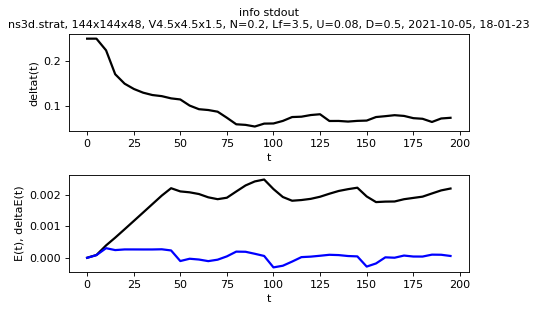

In [18]:
sim.output.print_stdout.plot()

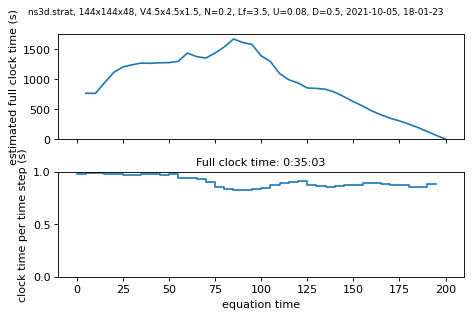

In [19]:
sim.output.print_stdout.plot_clock_times()

### Spatial means saved in spatial_means.txt

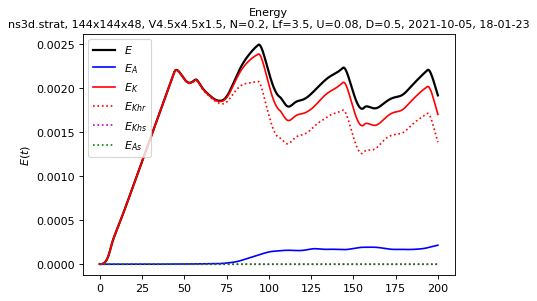

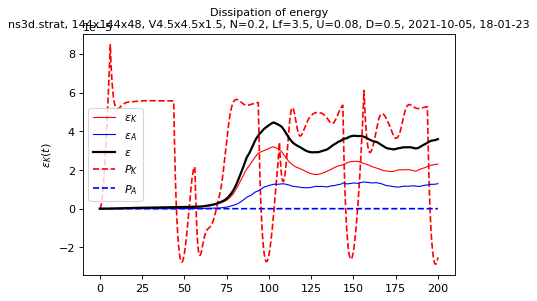

In [20]:
sim.output.spatial_means.plot()

In [21]:
info_forcing = sim.forcing.get_info()
info_forcing

{'period': 100.0}

In [22]:
period = info_forcing["period"]

In [23]:
sim.output.spatial_means.get_dimless_numbers_averaged?

Signature: sim.output.spatial_means.get_dimless_numbers_averaged(tmin=0, tmax=None)
Docstring: <no docstring>
File:      ~/Dev/fluidsim/fluidsim/solvers/ns3d/strat/output/spatial_means.py
Type:      method


In [24]:
dimless_numbers = sim.output.spatial_means.get_dimless_numbers_averaged(tmin=period)
dimless_numbers

{'Fh': 0.06714905252879659,
 'R2': 549.9712175,
 'R4': 463.93295568193037,
 'epsK2/epsK': 0.020934571946635557,
 'Gamma': 0.5615502543247894,
 'dimensional': {'Uh2': 0.0016521333500000002, 'epsK': 2.19988487e-05}}

### Spectra saved in spectra1d.h5

In [25]:
sim.output.spectra.plot1d?

Signature:
sim.output.spectra.plot1d(
    tmin=0,
    tmax=None,
    coef_compensate=0,
    coef_plot_k3=None,
    coef_plot_k53=None,
    coef_plot_k2=None,
    xlim=None,
    ylim=None,
    directions=('x', 'z'),
)
Docstring: <no docstring>
File:      ~/Dev/fluidsim/fluidsim/solvers/ns3d/output/spectra.py
Type:      method


plot1d(tmin=     100, tmax= 200.024, coef_compensate=1.667)
plot 1D spectra
tmin =  100.004 ; tmax =  200.024
imin =      100 ; imax =      200


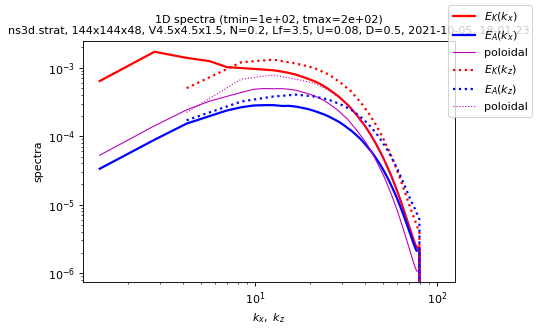

In [26]:
sim.output.spectra.plot1d(tmin=period, coef_compensate=5 / 3)

### Simple cross-sections of the flow fields



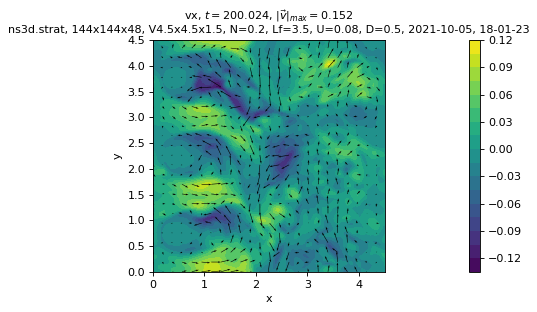

In [27]:
sim.output.phys_fields.plot()

In [28]:
sim.output.phys_fields.plot?

Signature:
sim.output.phys_fields.plot(
    field=None,
    time=None,
    QUIVER=True,
    vector='v',
    equation=None,
    nb_contours=20,
    type_plot='contourf',
    vmin=None,
    vmax=None,
    cmap=None,
    numfig=None,
    SCALED=True,
)
Docstring:
Plot a field.

Parameters
----------

field : {str, np.ndarray}, optional

time : number, optional

QUIVER : True

vecx : 'ux'

vecy : 'uy'

nb_contours : 20

type_plot : 'contourf'

vmin : None

vmax : None

cmap : None (usually 'viridis')

numfig : None
File:      ~/Dev/fluidsim/fluidsim/base/output/phys_fields3d.py
Type:      method


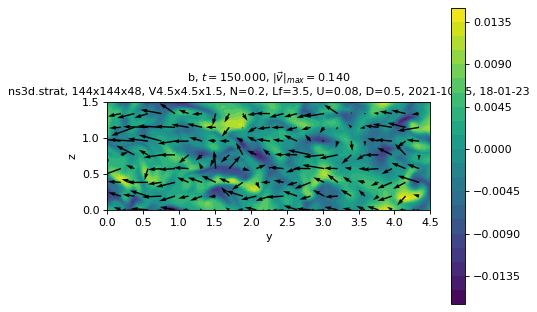

In [29]:
sim.output.phys_fields.plot(
    field="b", time=1.5 * period, equation=f"x={sim.params.oper.Lx/2}"
)

In [30]:
sim.output.phys_fields.animate?

Signature:
sim.output.phys_fields.animate(
    key_field=None,
    dt_frame_in_sec=0.3,
    dt_equations=None,
    tmin=None,
    tmax=None,
    repeat=True,
    save_file=False,
    numfig=None,
    fargs={},
    fig_kw={},
    **kwargs,
)
Docstring:
Load the key field from multiple save files and display as
an animated plot or save as a movie file.

Parameters
----------
key_field : str
    Specifies which field to animate
dt_frame_in_sec : float
    Interval between animated frames in seconds
dt_equations : float
    Approx. interval between saved files to load in simulation time
    units
tmax : float
    Animate till time `tmax`.
repeat : bool
    Loop the animation
save_file : str or bool
    Path to save the movie. When `True`  saves into a file instead
    of plotting it on screen (default: ~/fluidsim_movie.mp4). Specify
    a string to save to another file location. Format is autodetected
    from the filename extension.
numfig : int
    Figure number on the window
fargs : dic

### How to use Paraview or Visit?

For serious 3D representations, it is easy to use specialized software like Paraview or Visit. These programs are able to open .xmf files which describe how the physical fields are stored in the hdf5 / netcdf fluidsim files.

One needs to create the .xmf file with the command line tool `fluidsim-create-xml-description`.

In [31]:
! fluidsim-create-xml-description {sim.output.path_run}

Creation of the file /home/pierre/Sim_data/tutorial_parametric_study/ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.08_D0.5_2021-10-05_18-01-23/states_phys.xmf
Open it with a Xdmf reader to read the output files.


In [32]:
! ls {sim.output.path_run + "/*.xmf"}

/home/pierre/Sim_data/tutorial_parametric_study/ns3d.strat_144x144x48_V4.5x4.5x1.5_N0.2_Lf3.5_U0.08_D0.5_2021-10-05_18-01-23/states_phys.xmf


In [33]:
!head -20 {sim.output.path_run + "/states_phys.xmf"}

<?xml version="1.0" ?>
<!DOCTYPE Xdmf SYSTEM "Xdmf.dtd" []>
<Xdmf>
  <Domain>
    <Grid Name="TimeSeries" GridType="Collection"
          CollectionType="Temporal">
    
    <Grid Name="my_uniform_grid" GridType="Uniform">
      <Time Value="0.000000000" />
      <Topology TopologyType="3DCoRectMesh" Dimensions="48 144 144">
      </Topology>
      <Geometry GeometryType="Origin_DxDyDz">
        <DataItem Dimensions="3" NumberType="Float" Format="XML">
        0 0 0
        </DataItem>
        <DataItem Dimensions="3" NumberType="Float" Format="XML">
        0.03125 0.03125 0.03125
        </DataItem>
      </Geometry>



### Spatiotemporal spectra

In [34]:
sim.output.spatiotemporal_spectra.plot_temporal_spectra?

Signature:
sim.output.spatiotemporal_spectra.plot_temporal_spectra(
    key_field=None,
    tmin=0,
    tmax=None,
    dtype=None,
    xscale='log',
)
Docstring: plot the temporal spectra computed from the 4d spectra
File:      ~/Dev/fluidsim/fluidsim/base/output/spatiotemporal_spectra.py
Type:      method


load times series...


Output()

tmin= 102.115, tmax= 196.406, nit=13


Output()

performing time fft...
load times series...


Output()

tmin= 102.115, tmax= 196.406, nit=13


Output()

computing temporal spectra...


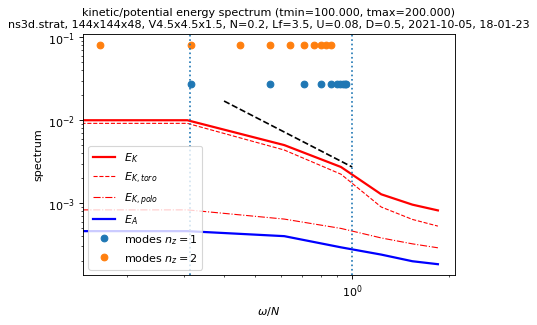

In [35]:
sim.output.spatiotemporal_spectra.plot_temporal_spectra(tmin=period)

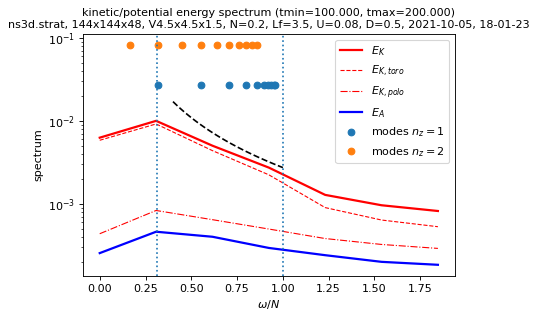

In [36]:
sim.output.spatiotemporal_spectra.plot_temporal_spectra(tmin=period, xscale="linear")

In [37]:
sim.output.spatiotemporal_spectra.plot_kzkhomega?

Signature:
sim.output.spatiotemporal_spectra.plot_kzkhomega(
    key_field=None,
    tmin=0,
    tmax=None,
    dtype=None,
    equation=None,
    xmax=None,
    ymax=None,
    cmap=None,
    vmin=None,
    vmax=None,
)
Docstring:
plot the spatiotemporal spectra, with a cylindrical average in k-space

equation must start with 'omega=', 'kh=', 'kz=', 'ikh=' or 'ikz='.
File:      ~/Dev/fluidsim/fluidsim/base/output/spatiotemporal_spectra.py
Type:      method


Computing spectra...
load times series...


Output()

tmin= 102.115, tmax= 196.406, nit=13


Output()

performing time fft...


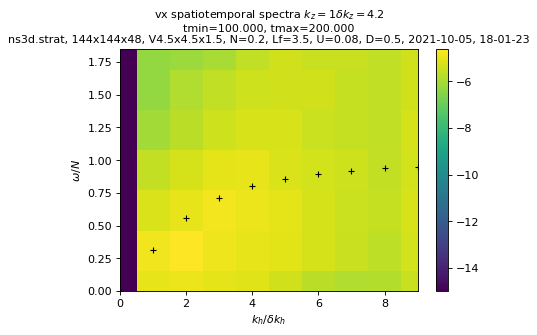

In [38]:
sim.output.spatiotemporal_spectra.plot_kzkhomega(tmin=period, equation="ikz=1")

Computing spectra...
load times series...


Output()

tmin= 102.115, tmax= 196.406, nit=13


Output()

performing time fft...
Computing ur, ud spectra...
load times series...


Output()

tmin= 102.115, tmax= 196.406, nit=13


Output()

computing temporal spectra...


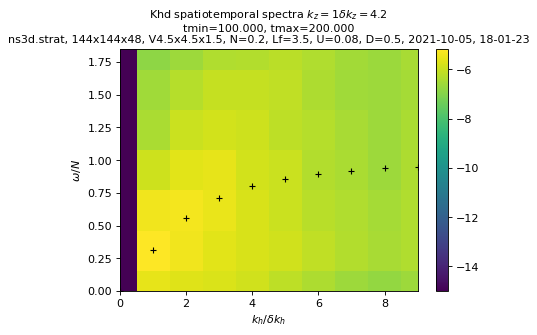

In [39]:
sim.output.spatiotemporal_spectra.plot_kzkhomega(
    key_field="Khd", tmin=period, equation="ikz=1"
)